### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# datasets
from sklearn.datasets import load_iris
from ucimlrepo import fetch_ucirepo 
from io import StringIO

# ordinal to binary 
from sbc import SBC

# discretization
from libraries.caimcaim import CAIMD # https://github.com/airysen/caimcaim/blob/master/caimcaim/caimcaim.py

# grid search
from sklearn.model_selection import GridSearchCV

# objective function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import torch

# evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

### datasets
- appendicitis: 7 medical measures taken over 106 patients on which the class label represents if the patient has appendicitis (class label 1) or not (class label 0).
- mammographic masses: discrimination of benign and malignant mammographic masses based on BI-RADS attributes and the patient's age.

In [2]:
with open('datasets/appendicitis.dat', "r") as file:
    lines = file.readlines()

data_start_ind = lines.index("@data\n") + 1
app_data = lines[data_start_ind:]
app_data = pd.read_csv(StringIO("".join(app_data)), header=None)

app_data.columns = ["At1", "At2", "At3", "At4", "At5", "At6", "At7", "Class"]

app_X = app_data.iloc[:, :-1]
app_y = app_data.iloc[:, -1]

print("num observations: ", app_y.count())
print("target distribution: ", app_y.value_counts())


app_X.describe()


num observations:  106
target distribution:  Class
0    85
1    21
Name: count, dtype: int64


,At1,At2,At3,At4,At5,At6,At7
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.398491,0.682104,0.415151,0.208745,0.169151,0.676349,0.375396
std,0.191452,0.207134,0.205799,0.199650,0.177329,0.218909,0.198132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.244750,0.589000,0.277000,0.056000,0.049250,0.576000,0.238000
50%,0.413000,0.750000,0.442500,0.146000,0.113000,0.744000,0.397500
75%,0.505750,0.821000,0.545500,0.302500,0.226750,0.831250,0.486750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
# fetch dataset 
mammo_data = fetch_ucirepo(id=161) 
  
# data (as pandas dataframes) 
mammo_X = mammo_data.data.features 
mammo_y = mammo_data.data.targets 

print("num observations: ", mammo_y.count())

# drop rows with nulls
mammo_combined = pd.concat([mammo_X, mammo_y], axis=1)
print("num rows with nulls: ", mammo_combined.isnull().sum().sum())
mammo_combined = mammo_combined.dropna()
mammo_combined = mammo_combined.reset_index(drop=True)
mammo_X = mammo_combined.iloc[:, :-1]
mammo_y = mammo_combined.iloc[:, -1]


# metadata 
# print(mammo_data.metadata) 
  
# variable information 
# print(mammo_data.variables) 

print("num observations: ", mammo_y.count())
print("target distribution: ", mammo_y.value_counts())

mammo_X.describe()

num observations:  Severity    961
dtype: int64
num rows with nulls:  162
num observations:  830
target distribution:  Severity
0    427
1    403
Name: count, dtype: int64


,BI-RADS,Age,Shape,Margin,Density
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663
std,1.888371,14.671782,1.242361,1.567175,0.350936
min,0.000000,18.000000,1.000000,1.000000,1.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000


In [4]:
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

aesthetic_evaluation_data.head()

,Subjective Evaluation,BRA Value,LBC Value,UNR Value,BCE Value,BCD Value,BAD Value,BOD Value,pBRA Value,pLBC Value,...,pBAD Value,pBOD Value,cX2L Value,cX2a Value,cX2b Value,cX2Lab Value,cEMDL Value,cEMDa Value,cEMDb Value,cEMDLab Value
0,Good,1.149009,0.830915,0.107618,0.938534,1.934477,4.885198,17.296370,0.049401,0.033356,...,0.029188,0.103340,0.097502,0.009506,0.217169,0.100670,1.503086,0.030362,0.291363,0.210082
1,Good,2.368824,1.326447,1.599444,0.272997,0.035378,19.932998,68.761479,0.113919,0.058509,...,0.117875,0.406627,0.305692,0.159653,0.193317,0.061736,1.248600,0.206529,0.351693,0.105346
2,Good,1.409939,0.950935,0.278358,1.229293,2.221074,22.277770,38.323430,0.067231,0.038613,...,0.120132,0.206658,0.109386,0.024217,0.280625,0.012974,0.545858,0.075520,0.304185,0.049345
3,Good,2.059918,0.720926,1.786307,1.065381,1.995007,25.163410,31.631070,0.100705,0.032141,...,0.156030,0.196133,0.038581,0.032267,0.026153,0.010779,0.334111,0.105626,0.137693,0.031455
4,Good,2.452595,0.798596,1.868745,1.070148,1.218189,0.395585,31.426783,0.117249,0.035235,...,0.002820,0.224062,0.021259,0.027071,0.029206,0.006495,0.165401,0.081549,0.091768,0.030546


In [5]:
aesthetic_evaluation_y.value_counts()

Subjective Evaluation
Good         595
Fair         353
Excellent    308
Poor         102
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Subjective Evaluation')

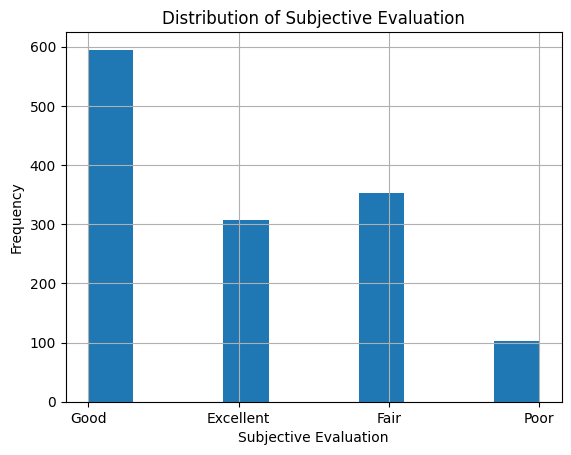

In [6]:
aesthetic_evaluation_y.hist()
plt.xlabel('Subjective Evaluation')
plt.ylabel('Frequency')
plt.title('Distribution of Subjective Evaluation')

In [7]:
# create binary target from aesthetic evaluation, by joining good and excellent, and fair and poor
aesthetic_evaluation_binary_y = aesthetic_evaluation_y.map({'Excellent': 1, 'Good': 1, 'Fair': 0, 'Poor': 0})

# distribution
aesthetic_evaluation_binary_y.value_counts()

Subjective Evaluation
1    903
0    455
Name: count, dtype: int64

### sbc reduction

In [8]:
sbc = SBC()
aesthetic_evaluation_new_X, aesthetic_evaluation_new_y, _, aesthetic_evaluation_new_data = sbc.reduction(aesthetic_evaluation_X, aesthetic_evaluation_y, h=1)

number of features:  22
original num target classes:  4
original num observations:  1358
mapping:  0         Good
1    Excellent
2         Fair
3         Poor
dtype: object
new num features:  23
new num target classes:  2
new num observations:  4074  (original num observations * 3 )
          0         1         2         3         4          5          6  \
0  1.149009  0.830915  0.107618  0.938534  1.934477   4.885198  17.296370   
1  1.149009  0.830915  0.107618  0.938534  1.934477   4.885198  17.296370   
2  1.149009  0.830915  0.107618  0.938534  1.934477   4.885198  17.296370   
3  2.368824  1.326447  1.599444  0.272997  0.035378  19.932998  68.761479   
4  2.368824  1.326447  1.599444  0.272997  0.035378  19.932998  68.761479   

          7         8         9  ...        14        15        16        17  \
0  0.049401  0.033356  0.005522  ...  0.097502  0.009506  0.217169  0.100670   
1  0.049401  0.033356  0.005522  ...  0.097502  0.009506  0.217169  0.100670   
2  0.049401  

### discretization thresholds
- CAIM
- infinitesimal bins

In [9]:
# discretize using CAIM
def discretize_caim_df(data, X, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    
    print("\nCut-off points: ", caim.split_scheme)
    print("Number of bins: ", end="")
    for i, (key, value) in enumerate(caim.split_scheme.items()):
        if i == len(caim.split_scheme) - 1:
            print(f" {key}: {len(value)+1}", end="")
        else:
            print(f" {key}: {len(value)+1}", end=",")
    print()
    
    X_disc_caim = pd.DataFrame(X_disc_caim, columns=X.columns).astype(int) # convert to pandas dataframe and int
        
    return X_disc_caim

''' 
prints of fit() method: Categorical list_of_(indicies)_categorical_features
    # feature_index  GLOBAL CAIM  best_caim_value 
in the returning dataframe:
    - columns represent the original features
    - rows represent each instance
    - values are the bin number each instance belongs to (starting from 0)
'''

def discretize_caim(X, cols, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    # get thresholds from caim.split_scheme (dict with column index : thresholds)
    # transform all values to floats
    # and keys with column indexes to column names
    thresholds = {cols[i]: [float(val) for val in value] for i, (key, value) in enumerate(caim.split_scheme.items())}
    print("\nthresholds ", thresholds)
    print("num of bins: ")
    for i, (key, value) in enumerate(thresholds.items()):
        print(f"  {key}: {len(value)+1}")
    return thresholds


In [10]:
# discretize using infinitesimal bins:
# thresholds are the points in between 2 consecutive values in the sorted list
def discretize_infbins(X, cols, y):
    infbins_thresholds = {}
    for col in cols:
        # sort unique values
        sorted_col = np.unique(X[col])
        # get thresholds
        thresholds = (sorted_col[:-1] + sorted_col[1:]) / 2
        infbins_thresholds[col] = thresholds.tolist()
    
    print("\nthresholds ", infbins_thresholds)
    print("num of bins: ")
    for key, value in infbins_thresholds.items():
        print(f"  {key}: {len(value)+1}")

    return infbins_thresholds

### discretized version
- 1 out of k
- differential coding

In [11]:
def get_bins(thresholds, values):
    bins = np.digitize(values, thresholds)
    return bins
    # list of bin number for each row

In [12]:
def disc_1_out_of_k(X, cols, thresholds):
    disc_df = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        bins_df = pd.get_dummies(bins, prefix=f'feat{col}-bin', prefix_sep='').astype(int) # one hot encoding
        for i in range(1, len(thresholds[col]) + 1):
            if f'feat{col}-bin{i}' not in bins_df.columns:
                bins_df[f'feat{col}-bin{i}'] = 0
        bins_df = bins_df.drop(columns=f'feat{col}-bin0', errors='ignore')
        disc_df.append(bins_df)    
    return pd.concat(disc_df, axis=1)


In [13]:
def disc_diff_coding(X, cols, thresholds):
    bin_dfs = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        num_bins = len(thresholds[col]) + 1
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bins >= i).astype(int)
        bin_dfs.append(bin_df)
    return pd.concat(bin_dfs, axis=1)

### objective functions
- LS
- maximum likelihood
- margin maximization

In [14]:
def grid_search(model, X, y, param_grid, cv=10):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)
    return grid_search

In [15]:
def get_weights(model, disc_X, y):
    model.fit(disc_X, y)
    weights = model.coef_[0]
    feature_names = disc_X.columns
    weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
    return weights_df

In [16]:
# RSS --> não está a funcionar pq Lasso tá à espera de valores contínuos
def rss(X, y): 
    linear_regression = Lasso()
    param_grid = {'alpha': [0.001, 0.01, 0.1, 0.4, 0.6, 0.9, 0.99, 1.0]}
    grid_search_rss = grid_search(linear_regression, X, y, param_grid)
    print("RSS best parameters: ", grid_search_rss.best_params_)
    best_model_rss = grid_search_rss.best_estimator_
    weights_rss = get_weights(best_model_rss, X, y)
    print("RSS weights:\n", weights_rss)

    # plot
    plt.figure()
    plt.bar(weights_rss['Feature'], weights_rss['Weight'])
    plt.xticks(rotation=90)
    plt.title('RSS weights')
    plt.show()

    return best_model_rss, weights_rss

In [17]:
# maximum likelihood (GLM with binomial response and logit link function)
def max_likelihood(X, y):
    logistic = LogisticRegression(solver = 'liblinear', penalty = 'l1')
    alpha_values = [0.001, 0.01, 0.1, 0.4, 0.6, 0.9, 1.0]
    param_grid = {'C': [1/a for a in alpha_values]} # inverse of regularization strength
    grid_search_logistic = grid_search(logistic, X, y, param_grid)
    print("ML best parameters: ", grid_search_logistic.best_params_)
    best_alpha = 1/grid_search_logistic.best_params_['C']
    print("ML best alpha: ", best_alpha)
    best_model_ml = grid_search_logistic.best_estimator_
    weights_ml = get_weights(best_model_ml, X, y)
    print("ML weights:\n", weights_ml)


    # plot weights
    plt.figure()
    plt.bar(weights_ml['Feature'], weights_ml['Weight'])
    plt.xticks(rotation=90)
    plt.title('ML weights')
    plt.show()

    return best_model_ml, weights_ml

In [18]:
# margin maximization (linear SVM)
def margin_max(X, y):
    param_grid = {
        'C': [2**i for i in range(-10, 11)],
        'class_weight': ['balanced', None],
    }
    svm = SVC(kernel='linear')
    #svm = svm_problem(app_y, disc_app_X)
    grid_search_svm = grid_search(svm, X, y, param_grid)
    best_model_svm = grid_search_svm.best_estimator_
    weights_svm = get_weights(best_model_svm, X, y)
    print("SVM weights:\n", weights_svm)

    # plot
    plt.figure()
    plt.bar(weights_svm['Feature'], weights_svm['Weight'])
    plt.xticks(rotation=90)
    plt.title('SVM weights')
    plt.show()

    return best_model_svm, weights_svm

### scorecard

In [19]:
def scorecard(X, y, disc_thresholds_method, disc_version_method, obj_function_method):
    # discretize
    thresholds = disc_thresholds_method(X, X.columns, y)
    disc_X = disc_version_method(X, X.columns, thresholds)
   
    # get weights
    model, weights = obj_function_method(disc_X, y)
    
    weights2 = weights[weights['Weight'] != 0]
    if weights2.shape[0] < weights.shape[0]:
        print("num of non-zero weights: ", weights2.shape[0])
        print("num of zero weights: ", weights.shape[0] - weights2.shape[0])
        print(weights2)
        plt.figure()
        plt.bar(weights2['Feature'], weights2['Weight'])
        plt.xticks(rotation=90)
        plt.show()

    return model, weights


### evaluation

In [20]:
def cross_val_score(model, X, y, n_splits=10):
    kf = StratifiedKFold(n_splits=n_splits)
    MSEs = [] # mean squared error
    accuracies = [] 
    AUCs = [] # area under the ROC curve
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        MSEs.append(mean_squared_error(y_test, y_pred))
        accuracies.append((y_pred == y_test).mean())
        #AUCs.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
        if hasattr(model, "predict_proba"):
            AUCs.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
        else:
            AUCs.append(roc_auc_score(y_test, y_pred))
        
    print("MSEs: ", MSEs)
    print("accuracies: ", accuracies)
    print("AUCs: ", AUCs)
    
    print("mean MSE: ", np.mean(MSEs))
    print("mean accuracy: ", np.mean(accuracies))
    print("mean AUC: ", np.mean(AUCs))
    return np.mean(MSEs), np.mean(accuracies), np.mean(AUCs)

### test

##### dataset: **appendicitis**; disc threshold: **CAIM**; disc method: **1 out of k**

In [21]:
app_thresholds = discretize_caim(app_X, app_X.columns, app_y)
app_disc_X = disc_1_out_of_k(app_X, app_X.columns, app_thresholds)

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4


RSS

In [22]:
#app_model_caim_1ook_rss, app_weights_caim_1ook_rss = scorecard(app_X, app_y, discretize_caim, disc_1_out_of_k, rss)

In [23]:
#app_scores_caim_1ook_rss, app_accuracies_caim_1ook_rss, app_AUCs_caim_1ook_rss = cross_val_score(app_model_caim_1ook_rss, app_X, app_y)

ML

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
ML best parameters:  {'C': 10.0}
ML best alpha:  0.1
ML weights:
          Feature    Weight
0   featAt1-bin1  0.265955
1   featAt1-bin2 -1.787776
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.496795
4   featAt2-bin2 -0.279051
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.258105
7   featAt3-bin2 -0.069907
8   featAt3-bin3  0.000000
9   featAt4-bin1  1.264117
10  featAt4-bin2 -0.723159
11  featAt4-bin3  0.000000
12  featAt5-bin1 -0.358033
13  featAt5-bin

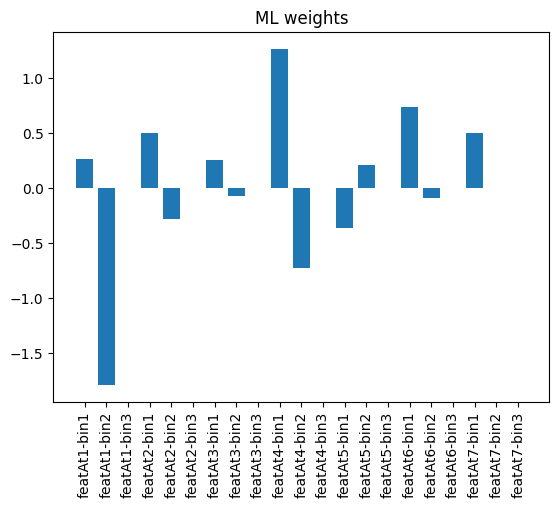

num of non-zero weights:  13
num of zero weights:  8
         Feature    Weight
0   featAt1-bin1  0.265955
1   featAt1-bin2 -1.787776
3   featAt2-bin1  0.496795
4   featAt2-bin2 -0.279051
6   featAt3-bin1  0.258105
7   featAt3-bin2 -0.069907
9   featAt4-bin1  1.264117
10  featAt4-bin2 -0.723159
12  featAt5-bin1 -0.358033
13  featAt5-bin2  0.208643
15  featAt6-bin1  0.736192
16  featAt6-bin2 -0.089213
18  featAt7-bin1  0.502369


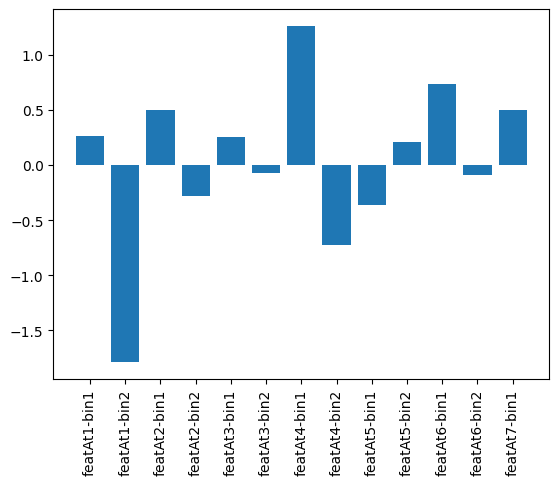

In [24]:
app_model_caim_1ook_ml, app_weights_caim_1ook_ml = scorecard(app_X, app_y, discretize_caim, disc_1_out_of_k, max_likelihood)

In [25]:
app_scores_caim_1ook_ml, app_accuracies_caim_1ook_ml, app_AUCs_caim_1ook_ml = cross_val_score(app_model_caim_1ook_ml, app_X, app_y)

MSEs:  [0.18181818181818182, 0.09090909090909091, 0.0, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.0, 0.2, 0.3, 0.2]
accuracies:  [0.8181818181818182, 0.9090909090909091, 1.0, 0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 1.0, 0.8, 0.7, 0.8]
AUCs:  [0.8333333333333333, 0.9444444444444444, 1.0, 0.5, 0.9444444444444444, 0.5, 1.0, 0.875, 0.625, 0.875]
mean MSE:  0.14272727272727273
mean accuracy:  0.8572727272727272
mean AUC:  0.8097222222222221


MM

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
SVM weights:
          Feature    Weight
0   featAt1-bin1  0.266763
1   featAt1-bin2 -0.266763
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.128510
4   featAt2-bin2 -0.128510
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.207379
7   featAt3-bin2 -0.207379
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.109489
10  featAt4-bin2 -0.109489
11  featAt4-bin3  0.000000
12  featAt5-bin1  0.079797
13  featAt5-bin2 -0.079797
14  featAt5-bin3  0.000000
15  featAt6-b

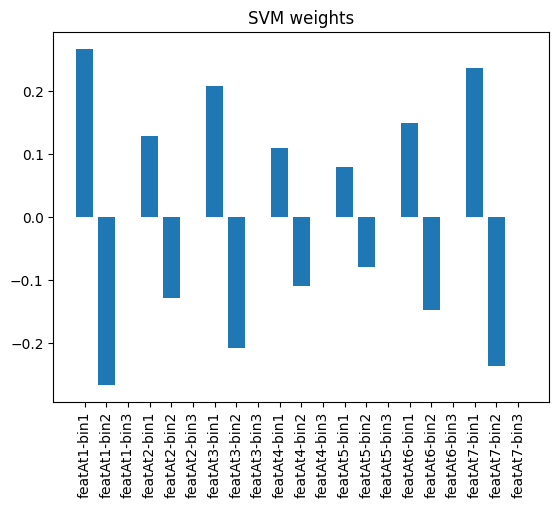

num of non-zero weights:  14
num of zero weights:  7
         Feature    Weight
0   featAt1-bin1  0.266763
1   featAt1-bin2 -0.266763
3   featAt2-bin1  0.128510
4   featAt2-bin2 -0.128510
6   featAt3-bin1  0.207379
7   featAt3-bin2 -0.207379
9   featAt4-bin1  0.109489
10  featAt4-bin2 -0.109489
12  featAt5-bin1  0.079797
13  featAt5-bin2 -0.079797
15  featAt6-bin1  0.148459
16  featAt6-bin2 -0.148459
18  featAt7-bin1  0.237071
19  featAt7-bin2 -0.237071


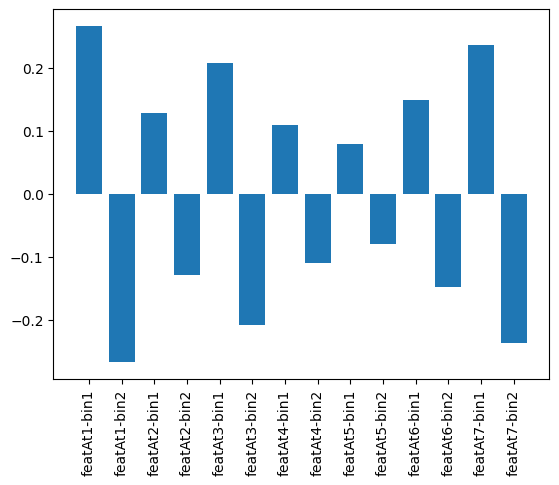

In [26]:
app_model_caim_1ook_mm, app_weights_caim_1ook_mm = scorecard(app_X, app_y, discretize_caim, disc_1_out_of_k, margin_max)

In [27]:
app_scores_caim_1ook_mm, app_accuracies_caim_1ook_mm, app_AUCs_caim_1ook_mm = cross_val_score(app_model_caim_1ook_mm, app_X, app_y)

MSEs:  [0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.45454545454545453, 0.0, 0.09090909090909091, 0.2, 0.2, 0.2, 0.2]
accuracies:  [0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.5454545454545454, 1.0, 0.9090909090909091, 0.8, 0.8, 0.8, 0.8]
AUCs:  [0.5, 0.8333333333333334, 0.8333333333333334, 0.5277777777777778, 1.0, 0.75, 0.5, 0.5, 0.5, 0.5]
mean MSE:  0.21636363636363637
mean accuracy:  0.7836363636363636
mean AUC:  0.6444444444444445


##### dataset: **appendicitis**; disc threshold: **CAIM**; disc method: **differential coding**

RSS

In [28]:
# app_model_caim_diffcoding_rss, app_weights_caim_diffcoding_rss = scorecard(app_X, app_y, discretize_caim, disc_diff_coding, rss)

In [29]:
# app_scores_caim_diffcoding_rss, app_accuracies_caim_diffcoding_rss, app_AUCs_caim_diffcoding_rss = cross_val_score(app_model_caim_diffcoding_rss, app_X, app_y)

ML

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
ML best parameters:  {'C': 10.0}
ML best alpha:  0.1
ML weights:
          Feature    Weight
0   featAt1-bin1  0.266990
1   featAt1-bin2 -2.045379
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.348027
4   featAt2-bin2 -0.746226
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.143010
7   featAt3-bin2 -0.270729
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.712773
10  featAt4-bin2 -1.939469
11  featAt4-bin3  0.000000
12  featAt5-bin1  0.000709
13  featAt5-bin

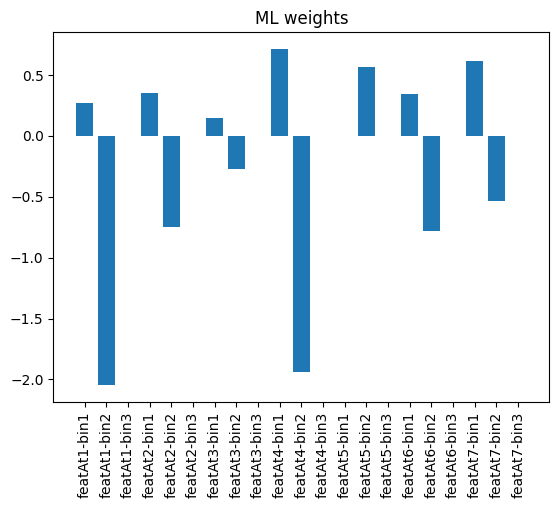

num of non-zero weights:  14
num of zero weights:  7
         Feature    Weight
0   featAt1-bin1  0.266990
1   featAt1-bin2 -2.045379
3   featAt2-bin1  0.348027
4   featAt2-bin2 -0.746226
6   featAt3-bin1  0.143010
7   featAt3-bin2 -0.270729
9   featAt4-bin1  0.712773
10  featAt4-bin2 -1.939469
12  featAt5-bin1  0.000709
13  featAt5-bin2  0.566230
15  featAt6-bin1  0.346849
16  featAt6-bin2 -0.782336
18  featAt7-bin1  0.611517
19  featAt7-bin2 -0.536184


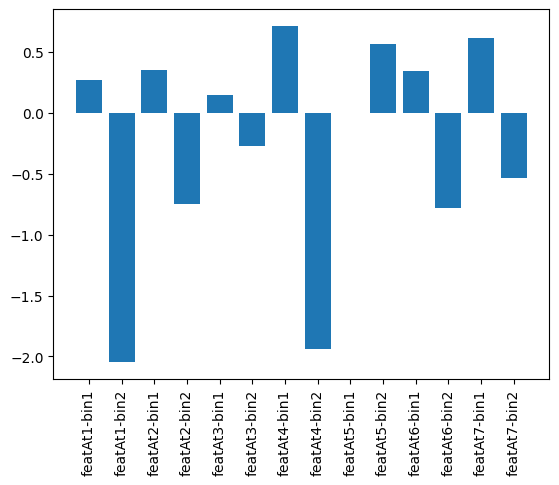

In [30]:
app_model_caim_diffcoding_ml, app_weights_caim_diffcoding_ml = scorecard(app_X, app_y, discretize_caim, disc_diff_coding, max_likelihood)

In [31]:
app_scores_caim_diffcoding_ml, app_accuracies_caim_diffcoding_ml, app_AUCs_caim_diffcoding_ml = cross_val_score(app_model_caim_diffcoding_ml, app_X, app_y)

MSEs:  [0.18181818181818182, 0.09090909090909091, 0.0, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.0, 0.2, 0.3, 0.2]
accuracies:  [0.8181818181818182, 0.9090909090909091, 1.0, 0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 1.0, 0.8, 0.7, 0.8]
AUCs:  [0.8333333333333333, 0.9444444444444444, 1.0, 0.5, 0.9444444444444444, 0.5, 1.0, 0.875, 0.625, 0.875]
mean MSE:  0.14272727272727273
mean accuracy:  0.8572727272727272
mean AUC:  0.8097222222222221


MM

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
SVM weights:
          Feature        Weight
0   featAt1-bin1 -8.326673e-16
1   featAt1-bin2 -5.335259e-01
2   featAt1-bin3  0.000000e+00
3   featAt2-bin1 -8.326673e-16
4   featAt2-bin2 -2.570203e-01
5   featAt2-bin3  0.000000e+00
6   featAt3-bin1 -8.326673e-16
7   featAt3-bin2 -4.147584e-01
8   featAt3-bin3  0.000000e+00
9   featAt4-bin1 -8.326673e-16
10  featAt4-bin2 -2.189776e-01
11  featAt4-bin3  0.000000e+00
12  featAt5-bin1 -8.326673e-16
13  featAt5

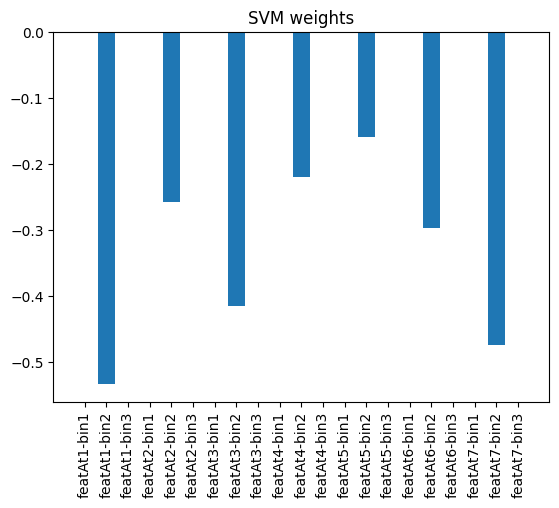

num of non-zero weights:  14
num of zero weights:  7
         Feature        Weight
0   featAt1-bin1 -8.326673e-16
1   featAt1-bin2 -5.335259e-01
3   featAt2-bin1 -8.326673e-16
4   featAt2-bin2 -2.570203e-01
6   featAt3-bin1 -8.326673e-16
7   featAt3-bin2 -4.147584e-01
9   featAt4-bin1 -8.326673e-16
10  featAt4-bin2 -2.189776e-01
12  featAt5-bin1 -8.326673e-16
13  featAt5-bin2 -1.595938e-01
15  featAt6-bin1 -8.326673e-16
16  featAt6-bin2 -2.969188e-01
18  featAt7-bin1 -8.326673e-16
19  featAt7-bin2 -4.741422e-01


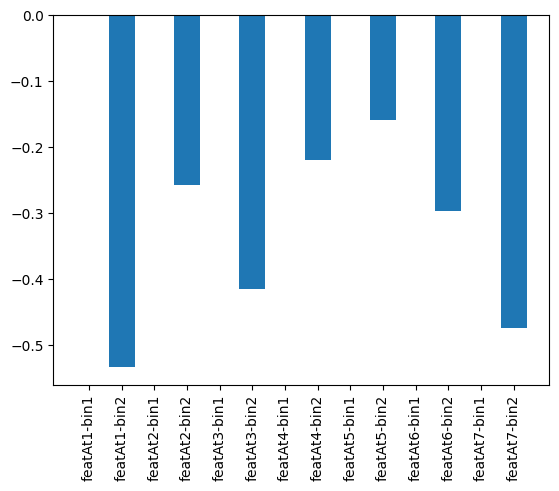

In [32]:
app_model_caim_diffcoding_mm, app_weights_caim_diffcoding_mm = scorecard(app_X, app_y, discretize_caim, disc_diff_coding, margin_max)

In [33]:
app_scores_caim_diffcoding_mm, app_accuracies_caim_diffcoding_mm, app_AUCs_caim_diffcoding_mm = cross_val_score(app_model_caim_diffcoding_mm, app_X, app_y)

MSEs:  [0.18181818181818182, 0.2727272727272727, 0.2727272727272727, 0.45454545454545453, 0.0, 0.09090909090909091, 0.0, 0.3, 0.4, 0.1]
accuracies:  [0.8181818181818182, 0.7272727272727273, 0.7272727272727273, 0.5454545454545454, 1.0, 0.9090909090909091, 1.0, 0.7, 0.6, 0.9]
AUCs:  [0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.5277777777777778, 1.0, 0.75, 1.0, 0.625, 0.5625, 0.9375]
mean MSE:  0.20727272727272728
mean accuracy:  0.7927272727272727
mean AUC:  0.773611111111111


##### dataset: **appendicitis**; disc threshold: **infinitesimal bins**; disc method: **1 out of k**

RSS

In [34]:
# app_model_infbins_1ook_rss, app_weights_infbins_1ook_rss = scorecard(app_X, app_y, discretize_infbins, disc_1_out_of_k, rss)

In [35]:
# app_scores_infbins_1ook_rss, app_accuracies_infbins_1ook_rss, app_AUCs_infbins_1ook_rss = cross_val_score(app_model_infbins_1ook_rss, app_X, app_y)

ML


thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 

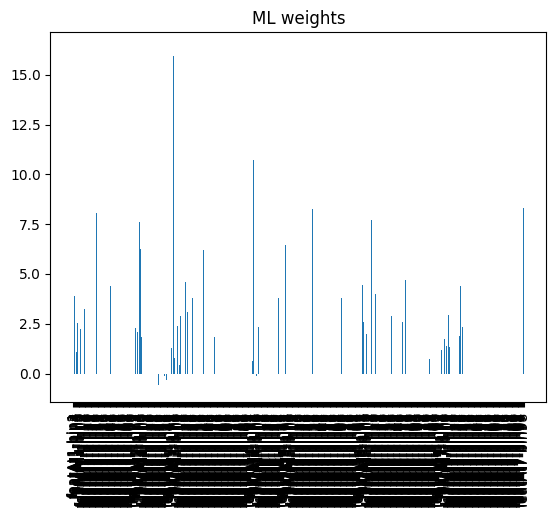

num of non-zero weights:  69
num of zero weights:  454
           Feature     Weight
1     featAt1-bin2   3.911729
4     featAt1-bin5   1.075563
5     featAt1-bin6   2.545769
8     featAt1-bin9   2.255258
10   featAt1-bin11  16.289966
..             ...        ...
449  featAt7-bin25   4.401577
451  featAt7-bin27   2.322242
467  featAt7-bin43   1.942482
468  featAt7-bin44   3.451232
522  featAt7-bin98   8.306340

[69 rows x 2 columns]


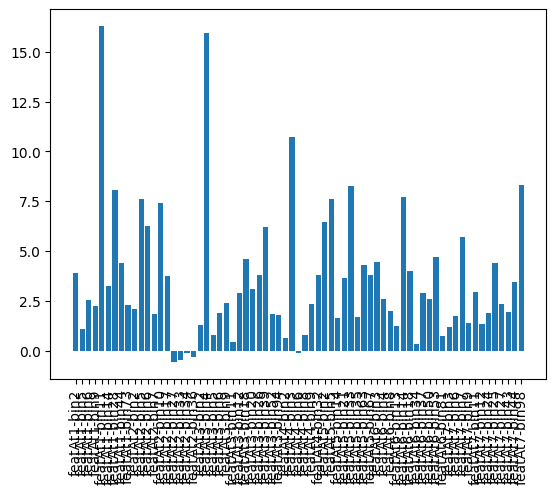

In [36]:
app_model_infbins_1ook_ml, app_weights_infbins_1ook_ml = scorecard(app_X, app_y, discretize_infbins, disc_1_out_of_k, max_likelihood)

In [37]:
app_scores_infbins_1ook_ml, app_accuracies_infbins_1ook_ml, app_AUCs_infbins_1ook_ml = cross_val_score(app_model_infbins_1ook_ml, app_X, app_y)

MSEs:  [0.18181818181818182, 0.09090909090909091, 0.0, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.1, 0.1, 0.2, 0.2]
accuracies:  [0.8181818181818182, 0.9090909090909091, 1.0, 0.8181818181818182, 0.9090909090909091, 0.9090909090909091, 0.9, 0.9, 0.8, 0.8]
AUCs:  [0.7916666666666667, 0.9444444444444444, 1.0, 0.5555555555555556, 0.9444444444444444, 0.5, 0.875, 0.875, 0.75, 0.8125]
mean MSE:  0.12363636363636363
mean accuracy:  0.8763636363636363
mean AUC:  0.804861111111111


/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


MM


thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 

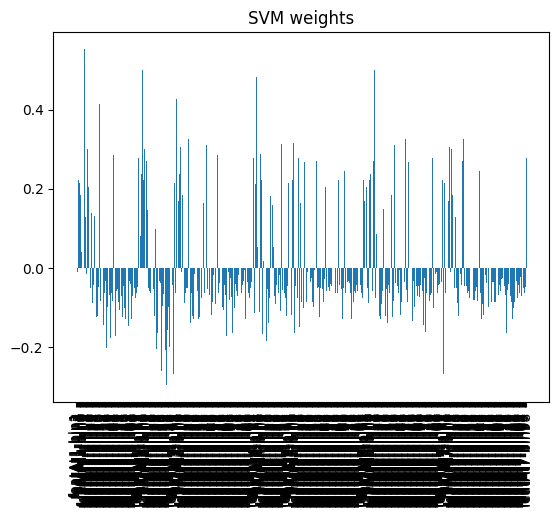

num of non-zero weights:  512
num of zero weights:  11
           Feature    Weight
0     featAt1-bin1 -0.062627
1     featAt1-bin2  0.313258
2     featAt1-bin3 -0.010897
3     featAt1-bin4  0.222931
4     featAt1-bin5  0.215703
..             ...       ...
518  featAt7-bin94 -0.035483
519  featAt7-bin95 -0.050812
520  featAt7-bin96 -0.063462
521  featAt7-bin97 -0.048621
522  featAt7-bin98  0.278121

[512 rows x 2 columns]


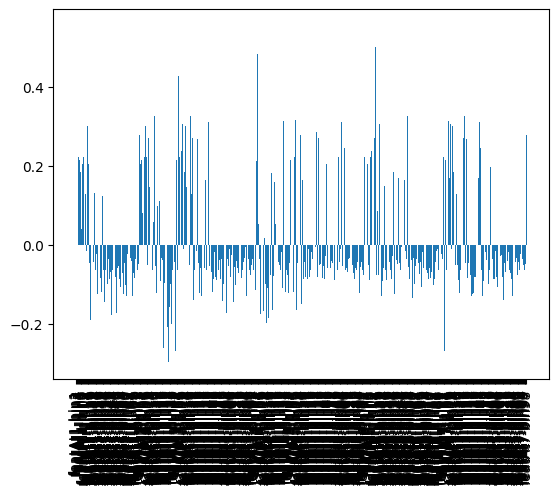

In [38]:
app_model_infbins_1ook_mm, app_weights_infbins_1ook_mm = scorecard(app_X, app_y, discretize_infbins, disc_1_out_of_k, margin_max)

In [39]:
app_scores_infbins_1ook_mm, app_accuracies_infbins_1ook_mm, app_AUCs_infbins_1ook_mm = cross_val_score(app_model_infbins_1ook_mm, app_X, app_y)

MSEs:  [0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.2, 0.1, 0.2, 0.3]
accuracies:  [0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 0.8, 0.9, 0.8, 0.7]
AUCs:  [0.5, 0.75, 0.75, 0.4444444444444444, 0.75, 0.75, 0.5, 0.75, 0.6875, 0.4375]
mean MSE:  0.17090909090909093
mean accuracy:  0.8290909090909091
mean AUC:  0.6319444444444444


##### dataset: **appendicitis**; disc threshold: **infinitesimal bins**; disc method: **differential coding**

RSS

In [40]:
# app_model_infbins_diffcoding_rss, app_weights_infbins_diffcoding_rss = scorecard(app_X, app_y, discretize_infbins, disc_diff_coding, rss)

In [41]:
# app_scores_infbins_diffcoding_rss, app_accuracies_infbins_diffcoding_rss, app_AUCs_infbins_diffcoding_rss = cross_val_score(app_model_infbins_diffcoding_rss, app_X, app_y)

ML


thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 

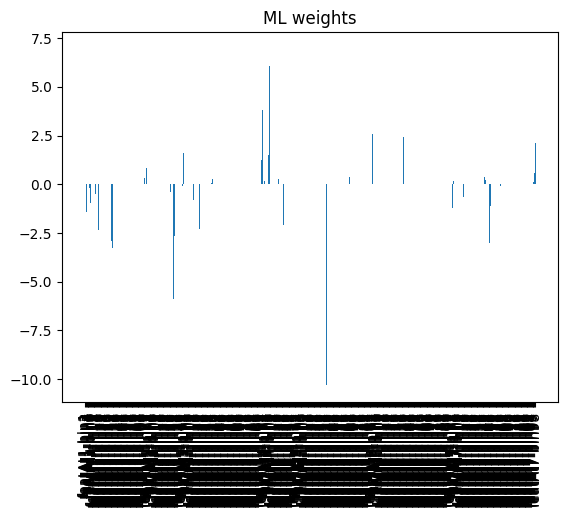

num of non-zero weights:  64
num of zero weights:  459
           Feature    Weight
0     featAt1-bin1 -0.001448
2     featAt1-bin3 -1.436886
5     featAt1-bin6 -0.197968
6     featAt1-bin7 -0.943711
12   featAt1-bin13 -0.517770
..             ...       ...
482  featAt7-bin58 -0.103591
484  featAt7-bin60 -0.006001
520  featAt7-bin96  0.110268
521  featAt7-bin97  0.573216
522  featAt7-bin98  2.123501

[64 rows x 2 columns]


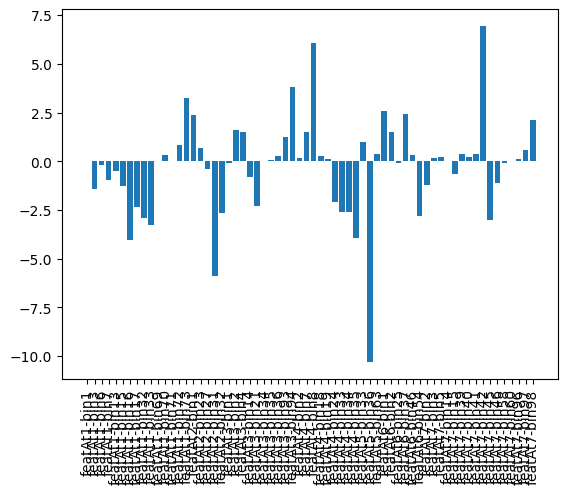

In [42]:
app_model_infbins_diffcoding_ml, app_weights_infbins_diffcoding_ml = scorecard(app_X, app_y, discretize_infbins, disc_diff_coding, max_likelihood)

In [43]:
app_scores_infbins_diffcoding_ml, app_accuracies_infbins_diffcoding_ml, app_AUCs_infbins_diffcoding_ml = cross_val_score(app_model_infbins_diffcoding_ml, app_X, app_y)

MSEs:  [0.18181818181818182, 0.09090909090909091, 0.0, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.0, 0.2, 0.2, 0.2]
accuracies:  [0.8181818181818182, 0.9090909090909091, 1.0, 0.8181818181818182, 0.9090909090909091, 0.9090909090909091, 1.0, 0.8, 0.8, 0.8]
AUCs:  [0.8333333333333333, 0.9444444444444444, 1.0, 0.5555555555555556, 0.9444444444444444, 0.5, 1.0, 0.875, 0.6875, 0.875]
mean MSE:  0.12363636363636363
mean accuracy:  0.8763636363636363
mean AUC:  0.8215277777777779


MM


thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 

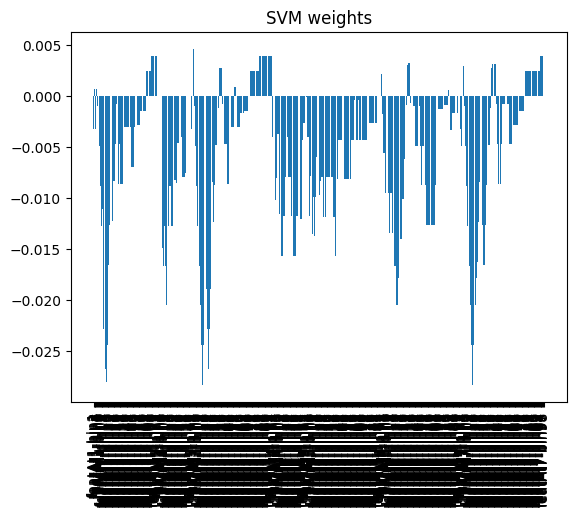

num of non-zero weights:  510
num of zero weights:  13
           Feature    Weight
0     featAt1-bin1 -0.003196
1     featAt1-bin2  0.000710
2     featAt1-bin3 -0.003196
3     featAt1-bin4  0.000710
4     featAt1-bin5 -0.000992
..             ...       ...
518  featAt7-bin94  0.003906
519  featAt7-bin95  0.003906
520  featAt7-bin96  0.003906
521  featAt7-bin97  0.003906
522  featAt7-bin98  0.003906

[510 rows x 2 columns]


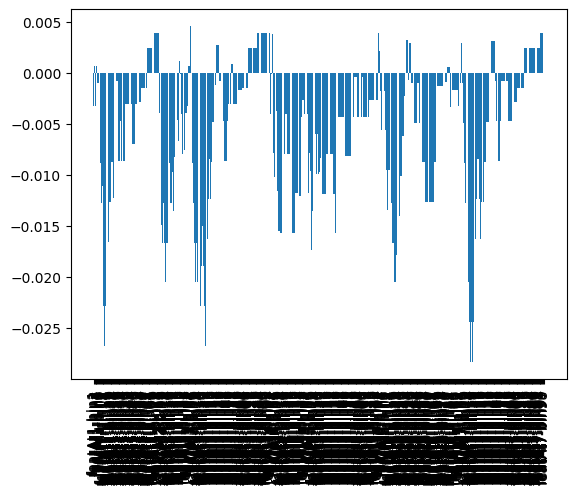

In [44]:
app_model_infbins_diffcoding_mm, app_weights_infbins_diffcoding_mm = scorecard(app_X, app_y, discretize_infbins, disc_diff_coding, margin_max)

In [45]:
app_scores_infbins_diffcoding_mm, app_accuracies_infbins_diffcoding_mm, app_AUCs_infbins_diffcoding_mm = cross_val_score(app_model_infbins_diffcoding_mm, app_X, app_y)

MSEs:  [0.2727272727272727, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.2, 0.2, 0.2, 0.2]
accuracies:  [0.7272727272727273, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8, 0.8, 0.8, 0.8]
AUCs:  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
mean MSE:  0.19818181818181818
mean accuracy:  0.8018181818181818
mean AUC:  0.5


test scorecard class


discretization thresholds
num of features:  5
Categorical []
# 0  GLOBAL CAIM  285.6742136527413
# 1  GLOBAL CAIM  200.56837074465608
# 2  GLOBAL CAIM  253.01568742655698
# 3  GLOBAL CAIM  248.36477272046983
# 4  GLOBAL CAIM  110.57423563701806

thresholds  {'BI-RADS': [0.0, 4.0, 56.0], 'Age': [18.0, 57.0, 97.0], 'Shape': [1.0, 2.0, 5.0], 'Margin': [1.0, 2.0, 6.0], 'Density': [1.0, 2.0, 5.0]}
num of bins: 
  BI-RADS: 4
  Age: 4
  Shape: 4
  Margin: 4
  Density: 4

encoding
t  [0.0, 4.0, 56.0]
0      5.0
1      5.0
2      4.0
3      5.0
4      5.0
      ... 
825    4.0
826    4.0
827    4.0
828    5.0
829    4.0
Name: BI-RADS, Length: 830, dtype: float64
t  [18.0, 57.0, 97.0]
0      67.0
1      58.0
2      28.0
3      57.0
4      76.0
       ... 
825    47.0
826    56.0
827    64.0
828    66.0
829    62.0
Name: Age, Length: 830, dtype: float64
t  [1.0, 2.0, 5.0]
0      3.0
1      4.0
2      1.0
3      1.0
4      1.0
      ... 
825    2.0
826    4.0
827    4.0
828    4.0
829    3.0
Name

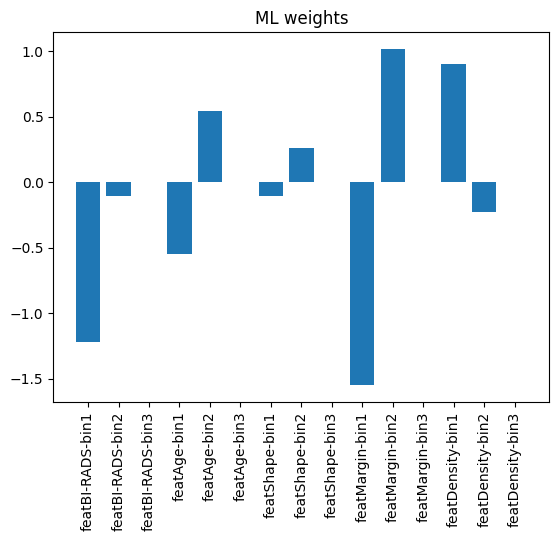

num of non-zero weights:  10
num of zero weights:  5
             Feature    Weight
0   featBI-RADS-bin1 -1.216530
1   featBI-RADS-bin2 -0.108600
3       featAge-bin1 -0.550258
4       featAge-bin2  0.543654
6     featShape-bin1 -0.104684
7     featShape-bin2  0.259278
9    featMargin-bin1 -1.547100
10   featMargin-bin2  1.014951
12  featDensity-bin1  0.900821
13  featDensity-bin2 -0.228707


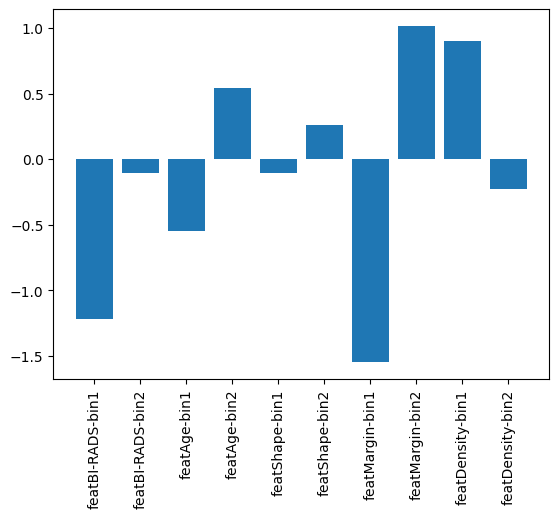

(LogisticRegression(C=1000.0, penalty='l1', solver='liblinear'),
              Feature    Weight
 0   featBI-RADS-bin1 -1.216530
 1   featBI-RADS-bin2 -0.108600
 2   featBI-RADS-bin3  0.000000
 3       featAge-bin1 -0.550258
 4       featAge-bin2  0.543654
 5       featAge-bin3  0.000000
 6     featShape-bin1 -0.104684
 7     featShape-bin2  0.259278
 8     featShape-bin3  0.000000
 9    featMargin-bin1 -1.547100
 10   featMargin-bin2  1.014951
 11   featMargin-bin3  0.000000
 12  featDensity-bin1  0.900821
 13  featDensity-bin2 -0.228707
 14  featDensity-bin3  0.000000)

In [46]:
from scorecard import Scorecard

scorecard = Scorecard()
scorecard.fit(mammo_X, mammo_y, 
                thresholds_method='CAIM',
                encoding_method='1_OUT_OF_K', 
                model_method='ML')

dataset used in paper 'Supersparse Linear Integer Models for Interpretable Classification'

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_data = fetch_ucirepo(id=15) 
  
# data (as pandas dataframes) 
breast_cancer_X = breast_cancer_data.data.features 
breast_cancer_y = breast_cancer_data.data.targets 
  
# metadata 
print(breast_cancer_data.metadata) 
  
# variable information 
print(breast_cancer_data.variables) 

{'uci_id': 15, 'name': 'Breast Cancer Wisconsin (Original)', 'repository_url': 'https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original', 'data_url': 'https://archive.ics.uci.edu/static/public/15/data.csv', 'abstract': 'Original Wisconsin Breast Cancer Database', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 699, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Class'], 'index_col': ['Sample_code_number'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1990, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5HP4Z', 'creators': ['WIlliam Wolberg'], 'intro_paper': None, 'additional_info': {'summary': "Samples arrive periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, having been removed fro

In [4]:
import pandas as pd

breast_cancer_combined = pd.concat([breast_cancer_X, breast_cancer_y], axis=1)
print("num rows with nulls: ", breast_cancer_combined.isnull().sum().sum())
breast_cancer_combined = breast_cancer_combined.dropna()
breast_cancer_combined = breast_cancer_combined.reset_index(drop=True)
breast_cancer_X = breast_cancer_combined.iloc[:, :-1]
breast_cancer_y = breast_cancer_combined.iloc[:, -1]

print("num observations: ", breast_cancer_y.count())

print("target distribution: ", breast_cancer_y.value_counts())

num rows with nulls:  0
num observations:  683
target distribution:  Class
2    444
4    239
Name: count, dtype: int64



discretization thresholds
num of features:  9
Categorical []
# 0  GLOBAL CAIM  252.36889617486338
# 1  GLOBAL CAIM  295.24042053740885
# 2  GLOBAL CAIM  292.41902267578087
# 3  GLOBAL CAIM  256.9620565454012
# 4  GLOBAL CAIM  278.09900416440337
# 5  GLOBAL CAIM  284.74833997343956
# 6  GLOBAL CAIM  281.41383247205863
# 7  GLOBAL CAIM  275.0902752931823
# 8  GLOBAL CAIM  198.78501868975016

thresholds  {'Clump_thickness': [1.0, 5.0, 11.0], 'Uniformity_of_cell_size': [1.0, 3.0, 11.0], 'Uniformity_of_cell_shape': [1.0, 3.0, 11.0], 'Marginal_adhesion': [1.0, 3.0, 11.0], 'Single_epithelial_cell_size': [1.0, 2.0, 11.0], 'Bare_nuclei': [1.0, 2.0, 11.0], 'Bland_chromatin': [1.0, 3.0, 11.0], 'Normal_nucleoli': [1.0, 2.0, 11.0], 'Mitoses': [1.0, 2.0, 11.0]}
num of bins: 
  Clump_thickness: 4
  Uniformity_of_cell_size: 4
  Uniformity_of_cell_shape: 4
  Marginal_adhesion: 4
  Single_epithelial_cell_size: 4
  Bare_nuclei: 4
  Bland_chromatin: 4
  Normal_nucleoli: 4
  Mitoses: 4

encoding

model
ML

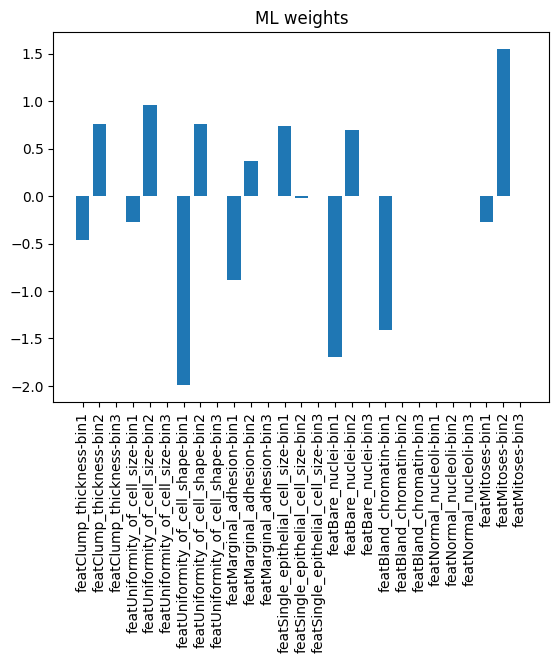

num of zero weights:  12
num of non-zero weights:  15
                                 Feature    Weight
0               featClump_thickness-bin1 -0.458283
1               featClump_thickness-bin2  0.758764
3       featUniformity_of_cell_size-bin1 -0.270327
4       featUniformity_of_cell_size-bin2  0.958044
6      featUniformity_of_cell_shape-bin1 -1.990431
7      featUniformity_of_cell_shape-bin2  0.763108
9             featMarginal_adhesion-bin1 -0.883632
10            featMarginal_adhesion-bin2  0.368765
12  featSingle_epithelial_cell_size-bin1  0.740533
13  featSingle_epithelial_cell_size-bin2 -0.018519
15                  featBare_nuclei-bin1 -1.699057
16                  featBare_nuclei-bin2  0.695329
18              featBland_chromatin-bin1 -1.413370
24                      featMitoses-bin1 -0.274536
25                      featMitoses-bin2  1.550676


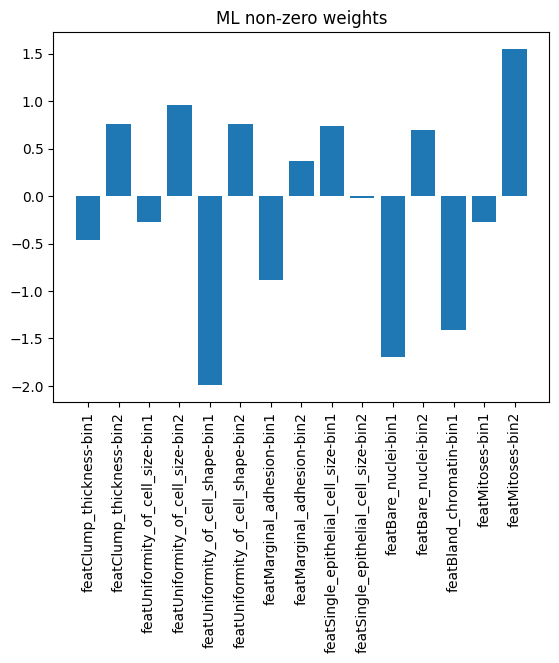

MSEs:  [0.2898550724637681, 0.11594202898550725, 0.2318840579710145, 0.23529411764705882, 0.0, 0.11764705882352941, 0.17647058823529413, 0.0, 0.11764705882352941, 0.0]
accuracies:  [0.927536231884058, 0.9710144927536232, 0.9420289855072463, 0.9411764705882353, 1.0, 0.9705882352941176, 0.9558823529411765, 1.0, 0.9705882352941176, 1.0]
AUCs:  [0.9879629629629629, 0.9990740740740741, 0.9796296296296296, 0.9922705314009661, 1.0, 0.9933712121212122, 0.9981060606060607, 1.0, 0.9990530303030303, 1.0]
mean MSE:  0.12847399829497017
mean accuracy:  0.9678815004262574
mean AUC:  0.9949467501097935


(0.12847399829497017, 0.9678815004262574, 0.9949467501097935)

In [11]:
from scorecard import Scorecard

scorecard = Scorecard()
scorecard.fit(breast_cancer_X, breast_cancer_y, 
                thresholds_method='CAIM',
                encoding_method='1_OUT_OF_K', 
                model_method='ML')
scorecard.cross_val_score()

In [12]:
num_nonzero_weights = scorecard.goal_num_nonzero_weights


discretization thresholds
num of features:  9
Categorical []
# 0  GLOBAL CAIM  252.36889617486338
# 1  GLOBAL CAIM  295.24042053740885
# 2  GLOBAL CAIM  292.41902267578087
# 3  GLOBAL CAIM  256.9620565454012
# 4  GLOBAL CAIM  278.09900416440337
# 5  GLOBAL CAIM  284.74833997343956
# 6  GLOBAL CAIM  281.41383247205863
# 7  GLOBAL CAIM  275.0902752931823
# 8  GLOBAL CAIM  198.78501868975016

thresholds  {'Clump_thickness': [1.0, 5.0, 11.0], 'Uniformity_of_cell_size': [1.0, 3.0, 11.0], 'Uniformity_of_cell_shape': [1.0, 3.0, 11.0], 'Marginal_adhesion': [1.0, 3.0, 11.0], 'Single_epithelial_cell_size': [1.0, 2.0, 11.0], 'Bare_nuclei': [1.0, 2.0, 11.0], 'Bland_chromatin': [1.0, 3.0, 11.0], 'Normal_nucleoli': [1.0, 2.0, 11.0], 'Mitoses': [1.0, 2.0, 11.0]}
num of bins: 
  Clump_thickness: 4
  Uniformity_of_cell_size: 4
  Uniformity_of_cell_shape: 4
  Marginal_adhesion: 4
  Single_epithelial_cell_size: 4
  Bare_nuclei: 4
  Bland_chromatin: 4
  Normal_nucleoli: 4
  Mitoses: 4

encoding

model
ML

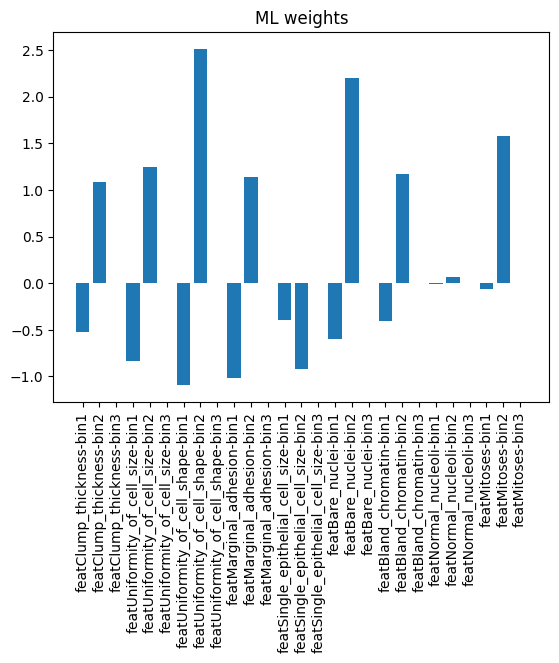

num of zero weights:  9
num of non-zero weights:  18
                                 Feature    Weight
0               featClump_thickness-bin1 -0.521848
1               featClump_thickness-bin2  1.082186
3       featUniformity_of_cell_size-bin1 -0.835053
4       featUniformity_of_cell_size-bin2  1.248943
6      featUniformity_of_cell_shape-bin1 -1.090961
7      featUniformity_of_cell_shape-bin2  2.513001
9             featMarginal_adhesion-bin1 -1.014590
10            featMarginal_adhesion-bin2  1.137829
12  featSingle_epithelial_cell_size-bin1 -0.389746
13  featSingle_epithelial_cell_size-bin2 -0.917592
15                  featBare_nuclei-bin1 -0.593641
16                  featBare_nuclei-bin2  2.204438
18              featBland_chromatin-bin1 -0.408070
19              featBland_chromatin-bin2  1.167190
21              featNormal_nucleoli-bin1 -0.004644
22              featNormal_nucleoli-bin2  0.069214
24                      featMitoses-bin1 -0.057219
25                      featM

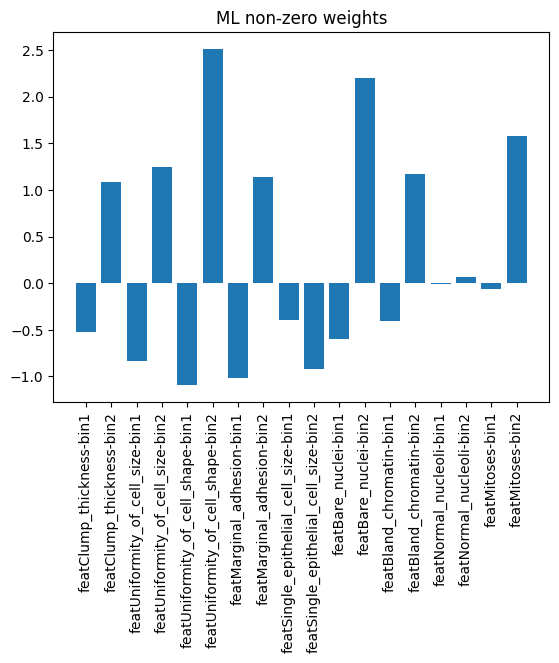

MSEs:  [0.2898550724637681, 0.11594202898550725, 0.2318840579710145, 0.23529411764705882, 0.0, 0.11764705882352941, 0.17647058823529413, 0.058823529411764705, 0.11764705882352941, 0.0]
accuracies:  [0.927536231884058, 0.9710144927536232, 0.9420289855072463, 0.9411764705882353, 1.0, 0.9705882352941176, 0.9558823529411765, 0.9852941176470589, 0.9705882352941176, 1.0]
AUCs:  [0.9879629629629629, 0.9990740740740741, 0.9824074074074075, 0.9922705314009661, 1.0, 0.9933712121212122, 0.9981060606060606, 1.0, 0.9990530303030303, 1.0]
mean MSE:  0.13435635123614662
mean accuracy:  0.9664109121909634
mean AUC:  0.9952245278875713


(0.13435635123614662, 0.9664109121909634, 0.9952245278875713)

In [ ]:
scorecard = Scorecard()

scorecard.fit(breast_cancer_X, breast_cancer_y,
                thresholds_method='CAIM',
                encoding_method='DIFF_CODING', 
                model_method='ML',
                use_sbc=False,
                num_nonzero_weights=num_nonzero_weights) 

scorecard.cross_val_score()


discretization thresholds

thresholds  {'Clump_thickness': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Uniformity_of_cell_size': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Uniformity_of_cell_shape': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Marginal_adhesion': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Single_epithelial_cell_size': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Bare_nuclei': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Bland_chromatin': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Normal_nucleoli': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Mitoses': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 9.0]}
num of bins: 
  Clump_thickness: 10
  Uniformity_of_cell_size: 10
  Uniformity_of_cell_shape: 10
  Marginal_adhesion: 10
  Single_epithelial_cell_size: 10
  Bare_nuclei: 10
  Bland_chromatin: 10
  Normal_nucleoli: 10
  Mitoses: 9

encoding

model
ML best parameters:  {'C': 1.6666666666666667}
ML best alpha:  0.6
ML weights:
                      Fea

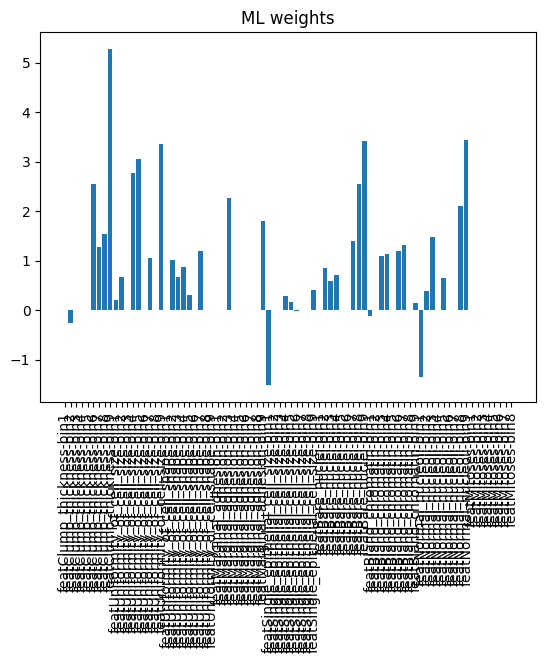

num of zero weights:  39
num of non-zero weights:  41
                                 Feature    Weight
1               featClump_thickness-bin2 -0.251790
5               featClump_thickness-bin6  2.553984
6               featClump_thickness-bin7  1.279063
7               featClump_thickness-bin8  1.533023
8               featClump_thickness-bin9  5.275266
9       featUniformity_of_cell_size-bin1  0.210086
10      featUniformity_of_cell_size-bin2  0.663377
12      featUniformity_of_cell_size-bin4  2.768509
13      featUniformity_of_cell_size-bin5  3.044704
15      featUniformity_of_cell_size-bin7  1.062241
17      featUniformity_of_cell_size-bin9  3.353293
19     featUniformity_of_cell_shape-bin2  1.019999
20     featUniformity_of_cell_shape-bin3  0.668650
21     featUniformity_of_cell_shape-bin4  0.874276
22     featUniformity_of_cell_shape-bin5  0.313882
24     featUniformity_of_cell_shape-bin7  1.193464
29            featMarginal_adhesion-bin3  2.266525
35            featMarginal_a

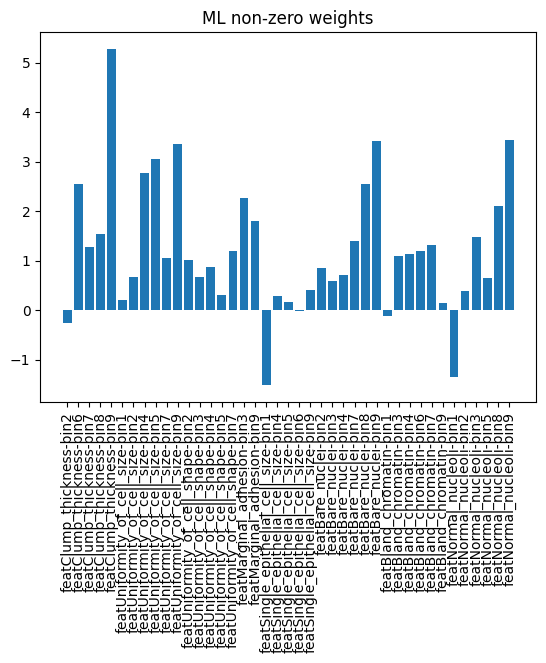

MSEs:  [0.2898550724637681, 0.11594202898550725, 0.2318840579710145, 0.23529411764705882, 0.0, 0.11764705882352941, 0.17647058823529413, 0.0, 0.11764705882352941, 0.0]
accuracies:  [0.927536231884058, 0.9710144927536232, 0.9420289855072463, 0.9411764705882353, 1.0, 0.9705882352941176, 0.9558823529411765, 1.0, 0.9705882352941176, 1.0]
AUCs:  [0.9879629629629629, 0.9990740740740741, 0.9814814814814815, 0.9922705314009661, 1.0, 0.9933712121212122, 0.9981060606060606, 1.0, 0.9990530303030303, 1.0]
mean MSE:  0.12847399829497017
mean accuracy:  0.9678815004262574
mean AUC:  0.9951319352949788


In [15]:
scorecard = Scorecard()

scorecard.fit(breast_cancer_X, breast_cancer_y,
                thresholds_method='INF_BINS',
                encoding_method='1_OUT_OF_K', 
                model_method='ML')
scorecard.cross_val_score()
num_nonzero_weights = scorecard.goal_num_nonzero_weights


discretization thresholds

thresholds  {'Clump_thickness': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Uniformity_of_cell_size': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Uniformity_of_cell_shape': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Marginal_adhesion': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Single_epithelial_cell_size': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Bare_nuclei': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Bland_chromatin': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Normal_nucleoli': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], 'Mitoses': [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 9.0]}
num of bins: 
  Clump_thickness: 10
  Uniformity_of_cell_size: 10
  Uniformity_of_cell_shape: 10
  Marginal_adhesion: 10
  Single_epithelial_cell_size: 10
  Bare_nuclei: 10
  Bland_chromatin: 10
  Normal_nucleoli: 10
  Mitoses: 9

encoding

model
ML best parameters:  {'C': 1.0}
ML best alpha:  1.0
ML weights:
                      Feature  Weight
0 

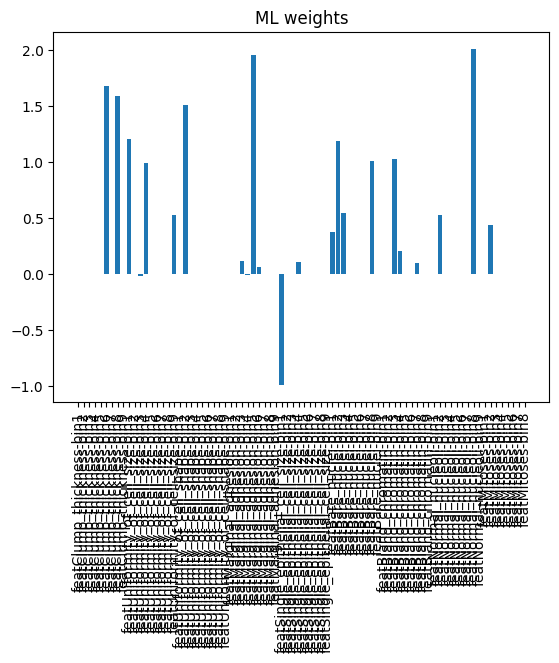

num of zero weights:  57
num of non-zero weights:  23
                                 Feature    Weight
5               featClump_thickness-bin6  1.684788
7               featClump_thickness-bin8  1.592864
9       featUniformity_of_cell_size-bin1  1.205903
11      featUniformity_of_cell_size-bin3 -0.016717
12      featUniformity_of_cell_size-bin4  0.992643
17      featUniformity_of_cell_size-bin9  0.525771
19     featUniformity_of_cell_shape-bin2  1.511191
29            featMarginal_adhesion-bin3  0.113784
30            featMarginal_adhesion-bin4 -0.009467
31            featMarginal_adhesion-bin5  1.956800
32            featMarginal_adhesion-bin6  0.067874
36  featSingle_epithelial_cell_size-bin1 -0.990687
39  featSingle_epithelial_cell_size-bin4  0.107533
45                  featBare_nuclei-bin1  0.380435
46                  featBare_nuclei-bin2  1.191748
47                  featBare_nuclei-bin3  0.544736
52                  featBare_nuclei-bin8  1.009714
56              featBland_ch

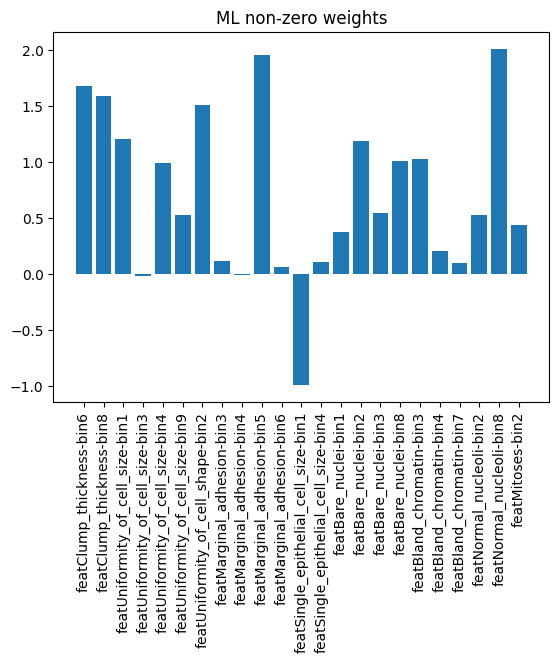

MSEs:  [0.2898550724637681, 0.11594202898550725, 0.2318840579710145, 0.23529411764705882, 0.0, 0.11764705882352941, 0.17647058823529413, 0.058823529411764705, 0.11764705882352941, 0.0]
accuracies:  [0.927536231884058, 0.9710144927536232, 0.9420289855072463, 0.9411764705882353, 1.0, 0.9705882352941176, 0.9558823529411765, 0.9852941176470589, 0.9705882352941176, 1.0]
AUCs:  [0.9879629629629629, 0.9990740740740741, 0.9833333333333334, 0.9922705314009661, 1.0, 0.9924242424242424, 0.9981060606060606, 1.0, 0.9990530303030303, 1.0]
mean MSE:  0.13435635123614662
mean accuracy:  0.9664109121909634
mean AUC:  0.995222423510467


(0.13435635123614662, 0.9664109121909634, 0.995222423510467)

In [19]:
scorecard = Scorecard()

scorecard.fit(breast_cancer_X, breast_cancer_y,
                thresholds_method='INF_BINS',
                encoding_method='DIFF_CODING', 
                model_method='ML',
                use_sbc=False,
                num_nonzero_weights=5)

scorecard.cross_val_score()